In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../data/stage1_train/'
TEST_PATH = '../data/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed


# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████| 670/670 [03:49<00:00,  2.92it/s]


Getting and resizing test images ... 


100%|██████████████████████████████████████████| 65/65 [00:01<00:00, 51.83it/s]


Done!


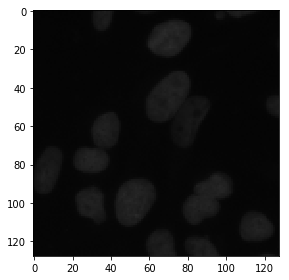

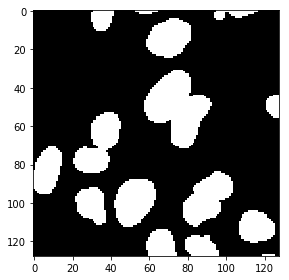

In [4]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()


# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [6]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 8)  224         lambda_2[0][0]                   
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 8)  584         conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [7]:

# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=8, epochs=10, 
                    callbacks=[earlystopper, checkpointer])
                    
                    
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))


Train on 536 samples, validate on 134 samples
Epoch 1/10
528/536 [============================>.] - ETA: 2:14 - loss: 0.7261 - mean_iou: 0.0000e+ - ETA: 1:24 - loss: 0.7091 - mean_iou: 0.1998   - ETA: 1:07 - loss: 0.7065 - mean_iou: 0.27 - ETA: 58s - loss: 0.7029 - mean_iou: 0.3073 - ETA: 52s - loss: 0.7005 - mean_iou: 0.328 - ETA: 48s - loss: 0.6986 - mean_iou: 0.344 - ETA: 45s - loss: 0.6971 - mean_iou: 0.356 - ETA: 42s - loss: 0.6959 - mean_iou: 0.365 - ETA: 40s - loss: 0.6951 - mean_iou: 0.371 - ETA: 39s - loss: 0.6943 - mean_iou: 0.376 - ETA: 37s - loss: 0.6936 - mean_iou: 0.380 - ETA: 36s - loss: 0.6928 - mean_iou: 0.384 - ETA: 35s - loss: 0.6918 - mean_iou: 0.387 - ETA: 34s - loss: 0.6910 - mean_iou: 0.389 - ETA: 33s - loss: 0.6902 - mean_iou: 0.391 - ETA: 32s - loss: 0.6894 - mean_iou: 0.393 - ETA: 31s - loss: 0.6889 - mean_iou: 0.395 - ETA: 30s - loss: 0.6884 - mean_iou: 0.396 - ETA: 29s - loss: 0.6868 - mean_iou: 0.398 - ETA: 28s - loss: 0.6858 - mean_iou: 0.399 - ETA: 28s - 

528/536 [============================>.] - ETA: 34s - loss: 0.3541 - mean_iou: 0.424 - ETA: 35s - loss: 0.3291 - mean_iou: 0.424 - ETA: 34s - loss: 0.3647 - mean_iou: 0.424 - ETA: 34s - loss: 0.3827 - mean_iou: 0.424 - ETA: 33s - loss: 0.3895 - mean_iou: 0.424 - ETA: 33s - loss: 0.3682 - mean_iou: 0.424 - ETA: 32s - loss: 0.3534 - mean_iou: 0.424 - ETA: 32s - loss: 0.3762 - mean_iou: 0.424 - ETA: 32s - loss: 0.3914 - mean_iou: 0.424 - ETA: 31s - loss: 0.3811 - mean_iou: 0.424 - ETA: 31s - loss: 0.3854 - mean_iou: 0.423 - ETA: 30s - loss: 0.3770 - mean_iou: 0.423 - ETA: 30s - loss: 0.3826 - mean_iou: 0.423 - ETA: 29s - loss: 0.3807 - mean_iou: 0.423 - ETA: 29s - loss: 0.3789 - mean_iou: 0.423 - ETA: 28s - loss: 0.3717 - mean_iou: 0.423 - ETA: 27s - loss: 0.3747 - mean_iou: 0.423 - ETA: 27s - loss: 0.3745 - mean_iou: 0.423 - ETA: 26s - loss: 0.3720 - mean_iou: 0.423 - ETA: 26s - loss: 0.3760 - mean_iou: 0.423 - ETA: 25s - loss: 0.3754 - mean_iou: 0.423 - ETA: 24s - loss: 0.3742 - mean_io

528/536 [============================>.] - ETA: 42s - loss: 0.1215 - mean_iou: 0.456 - ETA: 40s - loss: 0.1616 - mean_iou: 0.457 - ETA: 38s - loss: 0.1874 - mean_iou: 0.457 - ETA: 37s - loss: 0.1788 - mean_iou: 0.457 - ETA: 36s - loss: 0.1730 - mean_iou: 0.457 - ETA: 35s - loss: 0.1808 - mean_iou: 0.458 - ETA: 34s - loss: 0.1787 - mean_iou: 0.458 - ETA: 33s - loss: 0.1785 - mean_iou: 0.458 - ETA: 33s - loss: 0.1771 - mean_iou: 0.459 - ETA: 32s - loss: 0.1752 - mean_iou: 0.459 - ETA: 31s - loss: 0.1707 - mean_iou: 0.459 - ETA: 31s - loss: 0.1676 - mean_iou: 0.460 - ETA: 30s - loss: 0.1672 - mean_iou: 0.460 - ETA: 29s - loss: 0.1723 - mean_iou: 0.460 - ETA: 29s - loss: 0.1754 - mean_iou: 0.460 - ETA: 28s - loss: 0.1762 - mean_iou: 0.461 - ETA: 28s - loss: 0.1769 - mean_iou: 0.461 - ETA: 27s - loss: 0.1788 - mean_iou: 0.461 - ETA: 27s - loss: 0.1740 - mean_iou: 0.462 - ETA: 26s - loss: 0.1730 - mean_iou: 0.462 - ETA: 25s - loss: 0.1739 - mean_iou: 0.462 - ETA: 25s - loss: 0.1754 - mean_io

528/536 [============================>.] - ETA: 35s - loss: 0.1164 - mean_iou: 0.543 - ETA: 34s - loss: 0.1294 - mean_iou: 0.543 - ETA: 34s - loss: 0.1190 - mean_iou: 0.543 - ETA: 33s - loss: 0.1093 - mean_iou: 0.543 - ETA: 33s - loss: 0.1184 - mean_iou: 0.544 - ETA: 32s - loss: 0.1225 - mean_iou: 0.544 - ETA: 32s - loss: 0.1191 - mean_iou: 0.544 - ETA: 31s - loss: 0.1221 - mean_iou: 0.545 - ETA: 31s - loss: 0.1236 - mean_iou: 0.545 - ETA: 30s - loss: 0.1235 - mean_iou: 0.545 - ETA: 29s - loss: 0.1215 - mean_iou: 0.545 - ETA: 29s - loss: 0.1263 - mean_iou: 0.546 - ETA: 28s - loss: 0.1253 - mean_iou: 0.546 - ETA: 28s - loss: 0.1244 - mean_iou: 0.546 - ETA: 27s - loss: 0.1203 - mean_iou: 0.546 - ETA: 27s - loss: 0.1205 - mean_iou: 0.546 - ETA: 26s - loss: 0.1221 - mean_iou: 0.547 - ETA: 26s - loss: 0.1228 - mean_iou: 0.547 - ETA: 25s - loss: 0.1251 - mean_iou: 0.547 - ETA: 25s - loss: 0.1229 - mean_iou: 0.547 - ETA: 24s - loss: 0.1258 - mean_iou: 0.548 - ETA: 24s - loss: 0.1252 - mean_io

528/536 [============================>.] - ETA: 38s - loss: 0.0859 - mean_iou: 0.604 - ETA: 38s - loss: 0.0713 - mean_iou: 0.604 - ETA: 38s - loss: 0.0754 - mean_iou: 0.605 - ETA: 37s - loss: 0.1054 - mean_iou: 0.605 - ETA: 36s - loss: 0.1282 - mean_iou: 0.605 - ETA: 35s - loss: 0.1155 - mean_iou: 0.605 - ETA: 34s - loss: 0.1136 - mean_iou: 0.605 - ETA: 34s - loss: 0.1233 - mean_iou: 0.605 - ETA: 33s - loss: 0.1268 - mean_iou: 0.605 - ETA: 32s - loss: 0.1265 - mean_iou: 0.606 - ETA: 31s - loss: 0.1292 - mean_iou: 0.606 - ETA: 31s - loss: 0.1249 - mean_iou: 0.606 - ETA: 31s - loss: 0.1242 - mean_iou: 0.606 - ETA: 30s - loss: 0.1197 - mean_iou: 0.606 - ETA: 29s - loss: 0.1189 - mean_iou: 0.606 - ETA: 28s - loss: 0.1160 - mean_iou: 0.606 - ETA: 28s - loss: 0.1164 - mean_iou: 0.607 - ETA: 27s - loss: 0.1124 - mean_iou: 0.607 - ETA: 27s - loss: 0.1103 - mean_iou: 0.607 - ETA: 26s - loss: 0.1072 - mean_iou: 0.607 - ETA: 25s - loss: 0.1046 - mean_iou: 0.607 - ETA: 25s - loss: 0.1048 - mean_io

In [8]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
        

In [9]:

new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
    
    
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-2.csv', index=False)

In [10]:
sub.head()

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,44595 2 44848 9 45101 14 45357 14 45612 16 458...
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,27992 3 28247 5 28502 6 28759 5 29016 3
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,49769 5 50023 9 50276 13 50531 15 50786 17 510...
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,10637 5 10890 10 11144 12 11399 14 11654 15 11...
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,30876 6 31130 9 31374 22 31628 24 31882 26 321...
